In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import math
import PyUltraLight
import pyfftw
import os
import sys
import multiprocessing
import numpy
import numba
import h5py
from IPython.core.display import clear_output, display
%matplotlib inline

### Custom Fancy Matplotlib Legend Handler and Settings

In [11]:
matplotlib.rcParams['animation.embed_limit'] = 2**128

from matplotlib.legend_handler import HandlerLine2D
import matplotlib.path as mpath
from matplotlib.transforms import BboxTransformFrom, BboxTransformTo, Bbox

font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 12}
matplotlib.rc('font', **font)

class HandlerMiniatureLine(HandlerLine2D):
    """Custom class handling the lines in matplotlib legends"""
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):
        
        #orig_handle.set_xdata(np.log10(orig_handle.get_xdata())) #PART ONE OF LOGPLOT, DELETE FOR LINEAR
        
        legline, _ = HandlerLine2D.create_artists(self,legend, orig_handle,
                                xdescent, ydescent, width, height, fontsize, trans, )
        legline.set_data(*orig_handle.get_data())
        ext = mpath.get_paths_extents([orig_handle.get_path()])
        if ext.width == 0:
            ext.x0 -= 0.1
            ext.x1 += 0.1
        bbox0 = BboxTransformFrom(ext)
        bbox1 = BboxTransformTo(Bbox.from_bounds(xdescent, ydescent, width, height))
        
        legline.set_transform(bbox0 + bbox1 + trans)
        #orig_handle.set_xdata(np.power(10,orig_handle.get_xdata())) #PART TWO OF LOGPLOT, DELETE FOR LINEAR
        return legline,

### Define Axion Mass, Physical Constants and Code Units

In [12]:
axion_mass = 1e-10 *1.783e-36 #kg

hbar = 1.0545718e-34  # m^2 kg/s
parsec = 3.0857e16  # m
light_year = 9.4607e15  # m
omega_m0 = 0.3111
omega_lambda = 0.6889
H_0 = 67.66 * 1e3 / (parsec * 1e6)   # s^-1
solar_mass = 1.989e30  # kg
G = 6.67e-11  # N m^2 kg^-2

length_unit = (8 * np.pi * hbar ** 2 / (3 * axion_mass ** 2 * H_0 ** 2 * omega_m0)) ** 0.25
time_unit = (3 * H_0 ** 2 * omega_m0 / (8 * np.pi)) ** -0.5
mass_unit = (3 * H_0 ** 2 * omega_m0 / (8 * np.pi)) ** 0.25 * hbar ** 1.5 / (axion_mass ** 1.5 * G)

### Set Simulation Parameters

In [13]:
# Set number of threads to target
num_threads = multiprocessing.cpu_count()
print('Number of threads = ',num_threads)

# Set box size and resolution
length = np.sqrt(1.) * 10. # 1 code unit is ~121 kpc x (1e-23/m_a)^0.5
length_units = ''  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.
resol = 256 # It is recommended to check the upper bound on soliton mass for a given box size and resolution, should be even!
initial_z = 100. # redshift at simulation start
final_z = 95.
central_mass = 0.
c_mass_unit = '' # Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units

#Data to save
save_rho = True # Saves density data for entire 3D simulation grid
save_psi = True # Saves full complex field data for entire 3D simulation grid
save_plane_z = True # Saves density data for plane z = 0
save_plane_x = True# Saves density data for plane x = 0
save_plane_y = True# Saves density data for plane y = 0
save_energies = True # Saves integrated gravitational, kinetic and total energies as lists, scalefactor aswell
save_lineyz = False # Saves density data for line y,z = 0. Useful for examining intereference patterns. 
save_linexy = False #Saves density data for line x,y = 0
save_linexz= False #Saves density data for line x,z = 0
save_psiplane_x = False
save_psiplane_y = False
save_psiplane_z = False

#Formats to save
hdf5 = False
npz = False
npy = True

step_factor = 0.5  # Change this to a larger number if velocities are sufficiently low that constraint on timestep can be relaxed. 
skip_saves = 0.    # How many iterations are performed without saving data
save_path = 'Output'  # Set output directory

save_options = [save_rho,save_psi,save_plane_z,save_energies,
                save_lineyz,save_plane_x, save_plane_y, save_linexy, save_linexz,
                save_psiplane_x, save_psiplane_y, save_psiplane_z]

('Number of threads = ', 12)



### Set Initial Conditions:

In [14]:
#This function will be called to generate the initial psi-field
def initfunct(xarray,yarray,zarray):

    xs = np.zeros((resol,resol,resol))
    ys = np.zeros((resol,resol,resol))
    zs = np.zeros((resol,resol,resol))

    for i in range(resol):
        for j in range(resol):
            for k in range(resol):
                xs[i,j,k] = i
                ys[i,j,k] = j
                zs[i,j,k] = k
    
    
    R = resol * 2 # Size of ellipsoid (R = r^2 in paper)
    delta = R/5.
    a_ = (1/.5)**(1/3.)
    shp = [a_, a_, .5 * a_] # Shape of ellipsoid
    dty = 50. # actually square root of rho, not physical density
    drop = .1 
    fac = 100  
    num = 1 # number of overdensities
     
    fld = pyfftw.zeros_aligned((resol, resol, resol), dtype='complex128')
    ext_bnd = int(max(shp)*np.sqrt(R))+1
    cents = [[],[],[]]
    
    for elem in cents:
        elem.append(np.random.randint(0+ext_bnd, resol-ext_bnd))
        while len(elem) < num: 
            val = np.random.randint(0+ext_bnd, resol-ext_bnd)
            for pres in elem:
                    if abs(pres - val) > 2*ext_bnd:
                        elem.append(val)
    
    theta = 1. # offset for rotation
        
    for i in range(num): 
        
        cents[0][i] = resol/2-1 
        cents[1][i] = resol/2-1 
        cents[2][i] = resol/2-1 
        
        x_pr = np.sin(theta)*ys + np.cos(theta)*xs
        y_pr = np.cos(theta)*ys - np.sin(theta)*xs  
        
        c_x_rot = np.sin(theta)*(resol/2.-1) + np.cos(theta)*(resol/2.-1)
        c_y_rot = np.cos(theta)*(resol/2.-1) - np.sin(theta)*(resol/2.-1)
        
        x_pr_pr = np.sin(theta)*zs + np.cos(theta)*x_pr
        z_pr = np.cos(theta)*zs - np.sin(theta)*x_pr  
        
        c_x_rot_rot = np.sin(theta)*(resol/2.-1) + np.cos(theta)*(c_x_rot)
        c_z_rot = np.cos(theta)*(resol/2.-1) - np.sin(theta)*(c_x_rot)
           
        region = np.where((x_pr_pr - c_x_rot_rot)**2/(shp[0]**2) + (y_pr - c_y_rot)**2/(shp[1]**2) + (z_pr - c_z_rot)**2/(shp[2]**2) <= R, dty, 0)
        fld = np.where((x_pr_pr - c_x_rot_rot)**2/(shp[0]**2) + (y_pr - c_y_rot)**2/(shp[1]**2) + (z_pr - c_z_rot)**2/(shp[2]**2) > R, dty*np.exp(-(drop*(abs(R - ((x_pr_pr - c_x_rot_rot)**2/(shp[0]**2) + (y_pr - c_y_rot)**2/(shp[1]**2) + (z_pr - c_z_rot)**2/(shp[2]**2)))))**2), 0)
        fld2 = np.where(fld > dty/fac, 1, 0)
        fld = fld * fld2
        fld = region + fld
        fld2 = np.where(fld <= dty/fac, dty/fac, 0)
        fld = fld + fld2


        
############### Introducing rotation below. Comment out or set first gauss_param to zero for no rotation
        

    gauss_param = [0.5, 0, .5]
    gridspace = float(length/float(resol))


    xvec = np.array([[np.linspace((0 - resol/2+1) * gridspace, (resol - (resol/2)) * gridspace, resol)]])
    yvec = xvec.reshape(resol,1, 1)
    zvec = xvec.reshape(1,resol,1)
    ell = np.sqrt(xvec**2/shp[0]**2 + yvec**2/shp[1]**2 + zvec**2/shp[2]**2)


    vec = np.array(np.linspace((0 - resol/2+1) * gridspace, (resol - (resol/2)) * gridspace, resol)).reshape(resol, 1)
    yplane = np.hstack([vec for i in range(resol)])
    fully = np.vstack([yplane for i in range(resol)]).reshape((resol,resol,resol))
    fullx = np.transpose(fully, (2, 0, 1))
    fullz = np.transpose(fully, (1, 0, 2))


    def gaussian(g, x):
        return g[0]*np.exp(-((x - g[1])**2/(2*g[2]**2)))

    vel = np.zeros((resol,resol,resol))
    bins = np.zeros(resol/2)
    bins[0] = 0
    bins[1] = gridspace/2
    for i in range(2,resol/2):
        bins[i] = bins[i-1] + gridspace
    for i in range(resol/2-1):
        ring = np.where(np.logical_and(bins[i] <= ell, ell < bins[i+1]), gaussian(gauss_param, (bins[i] + bins[i+1])/2), 0)
        vel = vel + ring


    fld = fld * np.exp(1j * vel)
    
    return fld

    


# Run:

In [15]:
PyUltraLight.evolve(central_mass, num_threads, length, length_units, resol, initial_z, final_z, step_factor, skip_saves, save_options, save_path, npz, npy, hdf5, initfunct, c_mass_unit)



Complete.



# Visualisations:

In [16]:
with open('{}{}'.format(save_path, '/timestamp.txt'), 'r') as timestamp:
    ts = timestamp.read()
# ts = '2019.6.14_20:21:42_512'#'2019.6.12_20:01:22_384'
loc = save_path + '/' + ts

### Plot of energies over time:

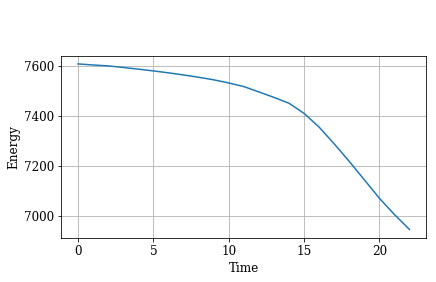

In [17]:
save_plots = 0
# 0 to display in this window without saving,
# 1 to save as well (will save in 'Visualisations' directory).

egylist = np.load('{}{}'.format(loc, '/egylist.npy')).tolist()
egpcmlist = np.load('{}{}'.format(loc, '/egpcmlist.npy')).tolist()
egpsilist = np.load('{}{}'.format(loc, '/egpsilist.npy')).tolist()
ekandqlist = np.load('{}{}'.format(loc, '/ekandqlist.npy')).tolist()
masslist = np.load('{}{}'.format(loc, '/masslist.npy')).tolist()
sflist = np.load('{}{}'.format(loc, '/scalefactorlist.npy')).tolist()

# plt.plot(abs((egylist-np.array(egylist[0]))/egylist[0]*100),label= 'Relative Error %: Total')
# plt.plot(egpcmlist,label='$E_{GP}$ (central potential)')
# plt.plot(egpsilist,label='$E_{GP}$ (self-interaction)')
# plt.plot(ekandqlist,label='$E_{K}+E_{Q}$')
# plt.plot(egylist, label='$E_{tot}$')
# plt.plot(sflist)
plt.plot(masslist)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), frameon=False, ncol=2)
#plt.axes().get_xaxis().set_ticks([])
plt.ylabel('Energy')
plt.xlabel('Time')
plt.grid()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
if save_plots == 1:
    plt.savefig('./Visualisations/energy_diagram.eps', format='eps', dpi=1000)
    plt.savefig('./Visualisations/energy_diagram.jpg', format='jpg', dpi=1000)
plt.show()

### Animation of planes of densitiy contours

In [18]:
save_plots = 0
# 0 to display in this window without saving,
# 1 to save as well (will save in 'Visualisations' directory).
plot_axis = 'z' #axis that is set to zero

plt.ioff()
fig0, ax0 = plt.subplots(figsize=(20, 10), dpi=50)
ax0.set_aspect('equal')

save_number = np.size(np.load('{}{}'.format(loc, '/masslist.npy')).tolist())-1
scalefactorlist = np.load('{}{}'.format(loc, '/scalefactorlist.npy'))
data0 = []
for x in np.arange(0,save_number+1,1):     
    data0.append(np.log10(np.load('{}{}{}{}{}{}'.format(loc, '/plane', plot_axis, '_#', x, '.npy'))))
planemax = np.max(data0)
planemin = np.min(data0)
levels = np.linspace(planemin, planemax, 50)

def animate0(i):
    ax0.cla()
    ax0.set_aspect('equal')
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    #ax0.contour(data0[i], levels=levels, vmin=planemin, vmax=planemax)
    ax0.imshow(data0[i])
    fig0.suptitle('{}{}{}'.format('Logarithmic Mass Density - plane ', plot_axis, '=0'), fontsize = 15)
    ax0.text(0.90, 1.1, '{}{}'.format('Frame ', i), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
    ax0.text(0.90, 1.05, '{}{}'.format(r'$a \approx$ ', np.around(scalefactorlist[i],2)), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
    
#Writer = matplotlib.animation.writers['ffmpeg']
#writer = Writer(fps=15, metadata=dict(artist='PyUltraLight'), bitrate=1800)

interval = 0.5 #in seconds
ani0 = matplotlib.animation.FuncAnimation(fig0,animate0,save_number+1,interval=interval*1e+3,blit=False)

from IPython.display import HTML
animated_plot0 = HTML(ani0.to_jshtml())

if save_plots == 1:  
    save_html0 = animated_plot0.data
    with open('{}{}{}'.format('./Visualisations/plane_animation', plot_axis, '_log10density.html'), 'w') as f:
        f.write(save_html0)
    #ani0.save('{}{}{}'.format('./Visualisations/plane', plot_axis, '_animation.mp4'), writer=writer)

fig0.clear()
display(animated_plot0) 

/Users/emily/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


<Figure size 1000x500 with 0 Axes>